In [72]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
pd.set_option('display.max_columns', None)



In [73]:

# Load the monthly CSV data
df = pd.read_csv('final_imputed.csv',index_col=0)

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Rename columns to standard names
column_mapping = {
    'committed_sign_revenue': 'committed_signed',
    'committed_unsig_revenue': 'committed_unsigned',
    'wtd_pipeline_revenue': 'wtd_pipeline'
}

# Apply mapping if columns exist
for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

# Create date column
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month_num'].astype(str) + '-01')
df = df.sort_values('date').reset_index(drop=True)

# Month name mapping
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['month_name'] = df['month_num'].map(month_names)

print(f"Data Shape: {df.shape}")
print(f"Date Range: {df['date'].min().strftime('%Y-%m')} to {df['date'].max().strftime('%Y-%m')}")
print(f"\n Columns: {df.columns.tolist()}")
print(f"\n Years in data: {sorted(df['year'].unique())}")
print(f"\n Data Sample:")
df.head(10)

Data Shape: (33, 10)
Date Range: 2023-03 to 2025-11

 Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline', 'committed_unsigned', 'committed_signed', 'avg_prob_pct', 'date', 'month_name']

 Years in data: [np.int64(2023), np.int64(2024), np.int64(2025)]

 Data Sample:


,year,month,month_num,actual_revenue,wtd_pipeline,committed_unsigned,committed_signed,avg_prob_pct,date,month_name
0,2023,Mar,3,143652715.03,149498941.00,225341482.19,892333074.90,1.08,2023-03-01,Mar
1,2023,Apr,4,124885992.08,128021173.76,175109527.78,846389431.63,0.30,2023-04-01,Apr
2,2023,May,5,138875729.02,111183171.12,136708061.66,794282160.04,0.32,2023-05-01,May
3,2023,Jun,6,141234442.90,101749224.51,129010801.06,678352187.48,0.23,2023-06-01,Jun
4,2023,Jul,7,129631649.98,70022906.88,120882243.46,599120331.40,0.24,2023-07-01,Jul
5,2023,Aug,8,136786674.92,53460896.02,79624297.60,539874324.04,0.23,2023-08-01,Aug
6,2023,Sept,9,144552454.11,32882039.33,65139252.86,443988665.68,0.20,2023-09-01,Sep
7,2023,Oct,10,134711395.83,14921180.07,54548073.12,338289696.97,0.19,2023-10-01,Oct
8,2023,Nov,11,139183383.31,7408016.67,30936483.51,237637016.98,0.17,2023-11-01,Nov
9,2023,Dec,12,140163210.50,5632607.43,24531533.83,209692686.88,0.11,2023-12-01,Dec


In [74]:

print("Missing Values Analysis:")

# Core columns
core_cols = ['actual_revenue', 'committed_signed', 'committed_unsigned', 'wtd_pipeline', 'avg_prob_pct']

for col in core_cols:
    if col in df.columns:
        missing = df[col].isna().sum()
        total = len(df)
        pct = (missing / total) * 100
        print(f"{col}: {missing}/{total} missing ({pct:.1f}%)")

        # Show which rows are missing
        if missing > 0:
            missing_rows = df[df[col].isna()][['year', 'month_num', 'month_name']]
            print(f"   Missing in: {missing_rows.to_dict('records')}")



Missing Values Analysis:
actual_revenue: 0/33 missing (0.0%)
committed_signed: 0/33 missing (0.0%)
committed_unsigned: 0/33 missing (0.0%)
wtd_pipeline: 0/33 missing (0.0%)
avg_prob_pct: 0/33 missing (0.0%)


In [75]:
def impute_decreasing_cumulative(df, col, decay_factor=0.92):
    
    df = df.copy()

    for year in df['year'].unique():
        year_mask = df['year'] == year
        year_df = df[year_mask].sort_values('month_num')

        for idx in year_df.index:
            if pd.isna(df.loc[idx, col]):
                month = df.loc[idx, 'month_num']
                remaining_months = 12 - month + 1

                # Try to get previous month's value
                prev_month_mask = (df['year'] == year) & (df['month_num'] == month - 1)
                if prev_month_mask.any():
                    prev_val = df.loc[prev_month_mask, col].values[0]
                    if not pd.isna(prev_val):
                        df.loc[idx, col] = prev_val * decay_factor
                        continue

                # Fallback: use same month from previous year with adjustment
                prev_year_mask = (df['year'] == year - 1) & (df['month_num'] == month)
                if prev_year_mask.any():
                    prev_year_val = df.loc[prev_year_mask, col].values[0]
                    if not pd.isna(prev_year_val):
                        df.loc[idx, col] = prev_year_val * 1.10
                        continue

                # Last fallback: use EWM of available values
                available = df[df[col].notna()][col]
                if len(available) > 0:
                    df.loc[idx, col] = available.ewm(span=6, adjust=False).mean().iloc[-1]

    return df

def impute_probability(df, col='avg_prob_pct'):
    
    df = df.copy()

    for idx in df.index:
        if pd.isna(df.loc[idx, col]):
            month = df.loc[idx, 'month_num']

            # Get same month from other years
            same_month = df[(df['month_num'] == month) & df[col].notna()][col]

            if len(same_month) > 0:
                df.loc[idx, col] = same_month.median()
            else:
                # Fallback to overall median
                df.loc[idx, col] = df[col].median()

    return df

# Apply imputation

# Impute cumulative forecast columns
for col in ['committed_signed', 'committed_unsigned', 'wtd_pipeline']:
    if col in df.columns:
        before_null = df[col].isna().sum()
        df = impute_decreasing_cumulative(df, col)
        after_null = df[col].isna().sum()
        print(f"   {col}: {before_null} → {after_null} nulls")

# Impute probability
if 'avg_prob_pct' in df.columns:
    before_null = df['avg_prob_pct'].isna().sum()
    df = impute_probability(df, 'avg_prob_pct')
    after_null = df['avg_prob_pct'].isna().sum()
    print(f"   avg_prob_pct: {before_null} → {after_null} nulls")

#print("\n Base feature imputation complete!")

   committed_signed: 0 → 0 nulls
   committed_unsigned: 0 → 0 nulls
   wtd_pipeline: 0 → 0 nulls
   avg_prob_pct: 0 → 0 nulls


In [78]:

print("Feature Engineering...")

def engineer_enhanced_features(df):
    
    df = df.copy().sort_values('date').reset_index(drop=True)



    # Total forecast
    df['total_forecast'] = (
        df['committed_signed'].fillna(0) +
        df['committed_unsigned'].fillna(0) +
        df['wtd_pipeline'].fillna(0)
    )

    # Remaining months in year (including current month)
    df['remaining_months'] = 12 - df['month_num'] + 1

    # CRITICAL: Monthly run rates from cumulative forecasts
    # This converts M→Dec cumulative to monthly figures
    df['signed_monthly_run_rate'] = df['committed_signed'] / df['remaining_months']
    df['unsigned_monthly_run_rate'] = df['committed_unsigned'] / df['remaining_months']
    df['pipeline_monthly_run_rate'] = df['wtd_pipeline'] / df['remaining_months']

    # Total forecast monthly run rate
    df['total_monthly_run_rate'] = (
        df['signed_monthly_run_rate'] +
        df['unsigned_monthly_run_rate'] +
        df['pipeline_monthly_run_rate']
    )

    # Conversion efficiency metrics
    df['signed_conversion_ratio'] = df['committed_signed'] / (df['total_forecast'] + 1e-10)
    df['pipeline_conversion_ratio'] = df['wtd_pipeline'] / (df['total_forecast'] + 1e-10)

    # Pipeline health score (combination of size and probability)
    #df['pipeline_health_score'] = df['wtd_pipeline'] * df['avg_prob_pct']

    # Signed coverage (how many months of revenue are secured)
    #df['signed_coverage_months'] = df['committed_signed'] / (df['actual_revenue'].rolling(3, min_periods=1).mean() + 1e-10)

    # Time pressure index (less time = more pressure)
    df['time_pressure'] = 1 / (df['remaining_months'] + 0.5)  # Inverse relationship

    # Quarter progression
    df['quarter'] = ((df['month_num'] - 1) // 3) + 1
    df['quarter_progress'] = ((df['month_num'] - 1) % 3) / 3

    # Business cycle position
    # Early (Jan-Apr), Mid (May-Aug), Late (Sep-Dec)
    df['business_cycle'] = pd.cut(df['month_num'],
                                  bins=[0, 4, 8, 13],
                                  labels=['early', 'mid', 'late'])
    cycle_map = {'early': 0, 'mid': 0.5, 'late': 1}
    df['business_cycle_score'] = df['business_cycle'].map(cycle_map).astype(float)

    # Year-to-date progress
    df['ytd_progress'] = (df['month_num'] - 1) / 11  # 0 to 1 scale

 
    # YoY growth rates (using SHIFT to avoid leakage)
    for col in ['committed_signed', 'wtd_pipeline']:
        df[f'{col}_yoy_growth'] = (
            (df[col] - df.groupby('month_num')[col].shift(1)) /
            (df.groupby('month_num')[col].shift(1) + 1e-10)
        )


    df['actual_revenue_yoy_growth']=df['actual_revenue'].shift(1)-df.groupby('month_num')['actual_revenue'].shift(2)/\
                                     (df.groupby('month_num')[col].shift(1) + 1e-10)

    # Month-over-month growth (momentum)
    df['revenue_mom_growth'] = df['actual_revenue'].shift(1).pct_change(1)
    df['signed_mom_growth'] = df['committed_signed'].pct_change(1)

    # Rolling growth rates (3-month smoothed)
    df['revenue_3m_growth'] = df['actual_revenue'].shift(1).pct_change(3)
    df['pipeline_3m_growth'] = df['wtd_pipeline'].pct_change(3)

    # Run rate gap analysis
    df['current_monthly_run'] = df['actual_revenue'].shift(1).rolling(3, min_periods=1).mean()
    df['required_monthly_run'] = df['signed_monthly_run_rate']
    df['run_rate_gap'] = df['required_monthly_run'] - df['current_monthly_run']
    df['run_rate_gap_pct'] = df['run_rate_gap'] / (df['current_monthly_run'] + 1e-10)

    # Forecast reliability index
    # df['forecast_reliability'] = (
    #     df['avg_prob_pct'] *
    #     (1 - df['pipeline_conversion_ratio'].abs())  # Lower conversion = more uncertainty
    # )

    # Business health composite score
    df['business_health'] = (
        0.4 * df['signed_conversion_ratio'] +  # Higher signed ratio = healthier
        0.3 * (1 - df['run_rate_gap_pct'].clip(-1, 1).abs()) +  # Smaller gap = healthier
        #0.2 * df['forecast_reliability'] +  # More reliable forecast = healthier
        0.2 * df['business_cycle_score']  # Later in cycle = more revenue realized
    )

    # Pressure × Efficiency interaction
    df['pressure_efficiency'] = df['time_pressure'] * df['signed_conversion_ratio']

    # Growth × Confidence interaction
    #df['growth_confidence'] = df['revenue_3m_growth'] * df['avg_prob_pct']

    # Pipeline × Time interaction (diminishing pipeline value over time)
    df['time_adjusted_pipeline'] = df['wtd_pipeline'] * np.exp(-0.1 * (df['remaining_months'] - 1))

    # Signed × Cycle interaction (signed matters more early in year)
    df['signed_cycle_importance'] = df['committed_signed'] * (1 - df['business_cycle_score'])

    # Log transforms for highly skewed variables
    df['log_signed_monthly'] = np.log1p(df['signed_monthly_run_rate'])
    df['log_pipeline_monthly'] = np.log1p(df['pipeline_monthly_run_rate'])
    df['log_actual_revenue_lag_1'] = np.log1p(df['actual_revenue'].shift(1))
    df['log_actual_revenue_lag_2'] = np.log1p(df['actual_revenue'].shift(2))
    df['log_actual_revenue_lag_3'] = np.log1p(df['actual_revenue'].shift(3))
    # Square root transforms (less aggressive than log)
    df['sqrt_total_forecast'] = np.sqrt(df['total_forecast'])

    # Polynomial terms for key predictors
    df['signed_monthly_squared'] = df['signed_monthly_run_rate'] ** 2
    df['pipeline_monthly_squared'] = df['pipeline_monthly_run_rate'] ** 2

    # Lagged features (SHIFTED to avoid target leakage)
    for lag in [1, 2, 3]:
        df[f'revenue_lag_{lag}'] = df['actual_revenue'].shift(lag)
        df[f'signed_runrate_lag_{lag}'] = df['signed_monthly_run_rate'].shift(lag)

    # EWM smoothing (using SHIFTED values)
    df['revenue_ewm_6m'] = df['actual_revenue'].shift(1).ewm(span=6, adjust=False).mean()
    df['signed_ewm_6m'] = df['signed_monthly_run_rate'].ewm(span=6, adjust=False).mean()

    # Rolling statistics (using SHIFTED values)
    df['revenue_rolling_3m_mean'] = df['actual_revenue'].shift(1).rolling(window=3, min_periods=1).mean()
    df['revenue_rolling_6m_std'] = df['actual_revenue'].shift(1).rolling(window=6, min_periods=1).std()

    # Pipeline conversion velocity
    df['pipeline_velocity'] = df['wtd_pipeline'] / (df['remaining_months'] + 0.5)

    # Signed deal momentum (acceleration)
    df['signed_momentum'] = df['signed_mom_growth'].diff(1)

    # Revenue predictability score
    df['revenue_predictability'] = 1 / (1 + df['revenue_rolling_6m_std'] / (df['revenue_rolling_3m_mean'] + 1e-10))

    # Forecast achievability score
    df['forecast_achievability'] = (
        df['signed_monthly_run_rate'] /
        (df['actual_revenue'].rolling(12, min_periods=1).mean() + 1e-10)
    ).clip(0, 3)  # Cap at 3x historical average

    # Business quarter intensity (Q4 typically highest)
    df['quarter_intensity'] = df['quarter'].map({1: 0.8, 2: 0.9, 3: 1.0, 4: 1.2})

    return df

# Apply enhanced feature engineering
df = engineer_enhanced_features(df)

# Display new features summary
original_columns = { 'year', 'month', 'month_num', 'actual_revenue','business_cycle',
                   'committed_signed', 'committed_unsigned', 'wtd_pipeline',
                   'avg_prob_pct', 'date', 'month_name'}
new_features = [col for col in df.columns if col not in original_columns]

print(f"\n Created {len(new_features)} new features!")
print(f" Total columns now: {df.shape[1]}")

# Categorize new features
feature_categories = {
    'CONVERSION METRICS': [col for col in new_features if any(x in col for x in ['run_rate', 'conversion', 'coverage', 'health_score'])],
    'TIME DYNAMICS': [col for col in new_features if any(x in col for x in ['time_pressure', 'quarter', 'cycle', 'progress'])],
    'GROWTH METRICS': [col for col in new_features if any(x in col for x in ['growth', 'momentum'])],
    'BUSINESS INTELLIGENCE': [col for col in new_features if any(x in col for x in ['run_rate_gap', 'reliability', 'business_health', 'predictability', 'achievability'])],
    'INTERACTION FEATURES': [col for col in new_features if any(x in col for x in ['pressure_efficiency', 'growth_confidence', 'time_adjusted', 'importance'])],
    'NON-LINEAR TRANSFORMS': [col for col in new_features if any(x in col for x in ['log_', 'sqrt_', '_squared'])],
    'TEMPORAL FEATURES': [col for col in new_features if any(x in col for x in ['lag_', 'ewm_', 'rolling_'])],
    'DOMAIN METRICS': [col for col in new_features if any(x in col for x in ['velocity', 'intensity'])]
}

print("\n FEATURE CATEGORIES CREATED:")
for category, features in feature_categories.items():
    if features:
        print(f"  {category}: {len(features)} features")

print("\n TOP 15 KEY FEATURES (Most Important for Business Logic):")
key_features = [
    'signed_monthly_run_rate',      # Monthly revenue target from signed deals
    'pipeline_monthly_run_rate',    # Monthly target from pipeline
    'signed_conversion_ratio',      # % of forecast already signed
    'time_pressure',                # Time pressure index
    'business_cycle_score',         # Position in annual cycle
    'revenue_3m_growth',            # Recent revenue growth
    'business_health',              # Composite business health score
    'run_rate_gap_pct',             # Gap between required and current run rate
    #'forecast_reliability',         # How reliable is the forecast
    'pressure_efficiency',          # Time pressure × conversion efficiency
    'log_signed_monthly',           # Log transform for skewed data
    'revenue_lag_1',                # Last month's revenue
    'revenue_ewm_6m',               # 6-month smoothed revenue
    'forecast_achievability',       # How achievable is forecast vs history
    'quarter_intensity'             # Quarter-specific intensity factor
]

for feat in key_features:
    if feat in df.columns:
        print(f"   {feat}")

Feature Engineering...

 Created 51 new features!
 Total columns now: 62

 FEATURE CATEGORIES CREATED:
  CONVERSION METRICS: 8 features
  TIME DYNAMICS: 7 features
  GROWTH METRICS: 8 features
  BUSINESS INTELLIGENCE: 5 features
  INTERACTION FEATURES: 3 features
  NON-LINEAR TRANSFORMS: 8 features
  TEMPORAL FEATURES: 13 features
  DOMAIN METRICS: 2 features

 TOP 15 KEY FEATURES (Most Important for Business Logic):
   signed_monthly_run_rate
   pipeline_monthly_run_rate
   signed_conversion_ratio
   time_pressure
   business_cycle_score
   revenue_3m_growth
   business_health
   run_rate_gap_pct
   pressure_efficiency
   log_signed_monthly
   revenue_lag_1
   revenue_ewm_6m
   forecast_achievability
   quarter_intensity


In [79]:


def impute_engineered_features(df, feature_groups=None):
    
    df = df.copy()

    # Default feature groups and methods
    if feature_groups is None:
        feature_groups = {
            'ffill': [
                'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3',
                'signed_runrate_lag_1', 'signed_runrate_lag_2', 'signed_runrate_lag_3',
                'revenue_ewm_6m', 'signed_ewm_6m', 'revenue_rolling_3m_mean',
                'signed_momentum','log_actual_revenue_lag_1','log_actual_revenue_lag_2',
                'log_actual_revenue_lag_3'
            ],
            'zero': [
                'revenue_mom_growth', 'signed_mom_growth',
                'revenue_3m_growth', 'pipeline_3m_growth',
                'revenue_rolling_6m_std', 'run_rate_gap', 'run_rate_gap_pct',
                'actual_revenue_yoy_growth', 'committed_signed_yoy_growth',
                'wtd_pipeline_yoy_growth'
            ],
            'interpolate': [
                'business_health', 'forecast_reliability', 'pressure_efficiency',
                'growth_confidence', 'revenue_predictability', 'forecast_achievability'
            ],
            'median': [
                'signed_conversion_ratio', 'pipeline_conversion_ratio',
                'signed_coverage_months', 'quarter_intensity'
            ]
        }

    # Apply imputation by method
    for method, features in feature_groups.items():
        for feat in features:
            if feat in df.columns:
                if method == 'ffill':
                    df[feat] = df[feat].ffill().bfill()
                elif method == 'zero':
                    df[feat] = df[feat].fillna(0)
                elif method == 'interpolate':
                    df[feat] = df[feat].interpolate(method='linear').ffill().bfill()
                elif method == 'median':
                    df[feat] = df[feat].fillna(df[feat].median())

    # Fill any remaining NaNs in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median() if df[col].notna().any() else 0)

    return df

# Apply imputation
print(" Imputing engineered features...")
df = impute_engineered_features(df)

# Verify no NaNs
null_counts = df.select_dtypes(include=[np.number]).isna().sum()
null_cols = null_counts[null_counts > 0]
if len(null_cols) > 0:
    print(f" Remaining nulls: {null_cols.to_dict()}")
else:
    print(" All engineered features imputed!")

 Imputing engineered features...
 All engineered features imputed!


In [80]:
# Feature categorization for enhanced feature set
CONVERSION_FEATURES = [
    'remaining_months',
    'signed_monthly_run_rate',
    'unsigned_monthly_run_rate',
    'pipeline_monthly_run_rate',
    'total_monthly_run_rate',
    'signed_conversion_ratio',
    'pipeline_conversion_ratio',
    'pipeline_health_score',
    'signed_coverage_months'
]

TIME_DYNAMICS_FEATURES = [
    'time_pressure',
    'quarter',
    'quarter_progress',
    'business_cycle_score',
    'ytd_progress'
]

GROWTH_FEATURES = [
    'actual_revenue_yoy_growth',
    'committed_signed_yoy_growth',
    'wtd_pipeline_yoy_growth',
    'revenue_mom_growth',
    'signed_mom_growth',
    'revenue_3m_growth',
    'pipeline_3m_growth'
]

BUSINESS_INTELLIGENCE_FEATURES = [
    'current_monthly_run',
    'required_monthly_run',
    'run_rate_gap',
    'run_rate_gap_pct',
    'forecast_reliability',
    'business_health'
]

INTERACTION_FEATURES = [
    'pressure_efficiency',
    'growth_confidence',
    'time_adjusted_pipeline',
    'signed_cycle_importance'
]

NONLINEAR_FEATURES = [
    'log_signed_monthly',
    'log_pipeline_monthly',
    'log_actual_revenue',
    'sqrt_total_forecast',
    'signed_monthly_squared',
    'pipeline_monthly_squared',
    'log_actual_revenue_lag_1',
    'log_actual_revenue_lag_2',
    'log_actual_revenue_lag_3'
]

TEMPORAL_FEATURES = [
    'revenue_lag_1',
    'revenue_lag_2',
    'revenue_lag_3',
    'signed_runrate_lag_1',
    'signed_runrate_lag_2',
    'signed_runrate_lag_3',
    'revenue_ewm_6m',
    'signed_ewm_6m',
    'revenue_rolling_3m_mean',
    'revenue_rolling_6m_std'
]

DOMAIN_METRICS_FEATURES = [
    'pipeline_velocity',
    'signed_momentum',
    'revenue_predictability',
    'forecast_achievability',
    'quarter_intensity'
]

# All features combined
ALL_FEATURES = (
    CONVERSION_FEATURES +
    TIME_DYNAMICS_FEATURES +
    GROWTH_FEATURES +
    BUSINESS_INTELLIGENCE_FEATURES +
    INTERACTION_FEATURES +
    NONLINEAR_FEATURES +
    TEMPORAL_FEATURES +
    DOMAIN_METRICS_FEATURES
)

# Filter to only features that exist in dataframe
ALL_FEATURES = [f for f in ALL_FEATURES if f in df.columns]

TARGET = 'actual_revenue'

print(f"   ENHANCED FEATURE COUNT BY CATEGORY:")
print(f"   Conversion Metrics: {len([f for f in CONVERSION_FEATURES if f in df.columns])}")
print(f"   Time Dynamics: {len([f for f in TIME_DYNAMICS_FEATURES if f in df.columns])}")
print(f"   Growth Metrics: {len([f for f in GROWTH_FEATURES if f in df.columns])}")
print(f"   Business Intelligence: {len([f for f in BUSINESS_INTELLIGENCE_FEATURES if f in df.columns])}")
print(f"   Interaction Features: {len([f for f in INTERACTION_FEATURES if f in df.columns])}")
print(f"   Non-linear Features: {len([f for f in NONLINEAR_FEATURES if f in df.columns])}")
print(f"   Temporal Features: {len([f for f in TEMPORAL_FEATURES if f in df.columns])}")
print(f"   Domain Metrics: {len([f for f in DOMAIN_METRICS_FEATURES if f in df.columns])}")
print(f"   TOTAL FEATURES: {len(ALL_FEATURES)}")
print(f"\n Target: {TARGET}")

   ENHANCED FEATURE COUNT BY CATEGORY:
   Conversion Metrics: 7
   Time Dynamics: 5
   Growth Metrics: 7
   Business Intelligence: 5
   Interaction Features: 3
   Non-linear Features: 8
   Temporal Features: 10
   Domain Metrics: 5
   TOTAL FEATURES: 50

 Target: actual_revenue


In [81]:
print(" Checking for target leakage...")

# Calculate correlations with target
correlations = df[ALL_FEATURES + [TARGET]].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)

print("\nTop 20 features by correlation with target:")
for feat, corr in correlations.head(20).items():
    status = " POTENTIAL LEAKAGE" if corr > 0.95 else " OK"
    print(f"   {feat}: {corr:.4f} {status}")

# Remove features with too high correlation (potential leakage)
leakage_features = correlations[correlations > 0.95].index.tolist()

if leakage_features:
    print(f"\n Removing potential leakage features: {leakage_features}")
    FINAL_FEATURES = [f for f in ALL_FEATURES if f not in leakage_features]
else:
    print("\n No target leakage detected!")
    FINAL_FEATURES = ALL_FEATURES.copy()

print(f"\n Final feature count after leakage check: {len(FINAL_FEATURES)}")

 Checking for target leakage...

Top 20 features by correlation with target:
   revenue_rolling_3m_mean: 0.9330  OK
   current_monthly_run: 0.9261  OK
   revenue_ewm_6m: 0.9217  OK
   revenue_lag_3: 0.9159  OK
   log_actual_revenue_lag_3: 0.9141  OK
   revenue_lag_1: 0.8912  OK
   log_actual_revenue_lag_1: 0.8861  OK
   revenue_lag_2: 0.8843  OK
   log_actual_revenue_lag_2: 0.8767  OK
   signed_ewm_6m: 0.8243  OK
   actual_revenue_yoy_growth: 0.7953  OK
   revenue_predictability: 0.6806  OK
   signed_runrate_lag_3: 0.6463  OK
   committed_signed_yoy_growth: 0.6206  OK
   log_signed_monthly: 0.6190  OK
   signed_monthly_run_rate: 0.5208  OK
   required_monthly_run: 0.5208  OK
   signed_conversion_ratio: 0.5030  OK
   total_monthly_run_rate: 0.4944  OK
   signed_runrate_lag_2: 0.4912  OK

 No target leakage detected!

 Final feature count after leakage check: 50


In [82]:
print("Checking for multicollinearity...")

# Calculate pairwise correlations
corr_matrix = df[FINAL_FEATURES].corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.90:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\n Found {len(high_corr_pairs)} highly correlated feature pairs:")

    features_to_drop = set()
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: -x[2])[:15]:
        # Keep the one more correlated with target
        corr1 = correlations.get(feat1, 0)
        corr2 = correlations.get(feat2, 0)

        if corr1 >= corr2:
            to_drop = feat2
            to_keep = feat1
        else:
            to_drop = feat1
            to_keep = feat2

        features_to_drop.add(to_drop)
        print(f"   {feat1} ↔ {feat2}: {corr:.3f} → Drop {to_drop}, Keep {to_keep}")

    FINAL_FEATURES = [f for f in FINAL_FEATURES if f not in features_to_drop]
    print(f"\n Removed {len(features_to_drop)} redundant features")
else:
    print(" No severe multicollinearity detected!")

print(f"\n Final feature count after multicollinearity check: {len(FINAL_FEATURES)}")
print(f"\n Final Features for Modeling: {FINAL_FEATURES}")

Checking for multicollinearity...

 Found 108 highly correlated feature pairs:
   signed_monthly_run_rate ↔ required_monthly_run: 1.000 → Drop required_monthly_run, Keep signed_monthly_run_rate
   remaining_months ↔ ytd_progress: 1.000 → Drop remaining_months, Keep ytd_progress
   log_actual_revenue_lag_2 ↔ revenue_lag_2: 0.999 → Drop log_actual_revenue_lag_2, Keep revenue_lag_2
   log_actual_revenue_lag_3 ↔ revenue_lag_3: 0.999 → Drop log_actual_revenue_lag_3, Keep revenue_lag_3
   time_pressure ↔ pressure_efficiency: 0.999 → Drop time_pressure, Keep pressure_efficiency
   log_actual_revenue_lag_1 ↔ revenue_lag_1: 0.999 → Drop log_actual_revenue_lag_1, Keep revenue_lag_1
   pipeline_monthly_run_rate ↔ pipeline_velocity: 0.998 → Drop pipeline_velocity, Keep pipeline_monthly_run_rate
   time_adjusted_pipeline ↔ pipeline_velocity: 0.996 → Drop time_adjusted_pipeline, Keep pipeline_velocity
   run_rate_gap ↔ run_rate_gap_pct: 0.995 → Drop run_rate_gap, Keep run_rate_gap_pct
   current_mon

In [90]:
full_features=['date']+FINAL_FEATURES
df[full_features].to_excel('saved.xlsx')

In [83]:
# ============================================
# STEP 10: TRAIN-TEST SPLIT
# ============================================

# Split data
train_df = df[df['year'].isin([2023, 2024])].copy()
test_df = df[df['year'] == 2025].copy()

# Remove rows where target is NaN in training data
train_df = train_df[train_df[TARGET].notna()]

print(f" Training Data: {len(train_df)} rows (2023-2024)")
print(f" Test Data: {len(test_df)} rows (2025)")
print(f"\n Training months: {train_df['year'].unique()} - {sorted(train_df['month_num'].unique())}")
print(f" Test months: {sorted(test_df['month_num'].unique())}")

# Check which test months have actual values
test_with_actual = test_df[test_df[TARGET].notna()]
test_without_actual = test_df[test_df[TARGET].isna()]

print(f"\n Test months with actual values: {sorted(test_with_actual['month_num'].unique())}")
print(f" Test months without actual (need EWM imputation): {sorted(test_without_actual['month_num'].unique())}")

 Training Data: 22 rows (2023-2024)
 Test Data: 11 rows (2025)

 Training months: [2023 2024] - [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
 Test months: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

 Test months with actual values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
 Test months without actual (need EWM imputation): []


In [84]:

def create_future_months_with_ewm(df, year, available_months, max_month=12, ewm_span=6):
    """
    Create rows for future months and impute features using EWM.
    """
    df = df.copy()

    # Find months that need to be created
    all_months = list(range(1, max_month + 1))
    existing_months = df[(df['year'] == year)]['month_num'].unique().tolist()
    missing_months = [m for m in all_months if m not in existing_months]

    if not missing_months:
        print(f" All months present for {year}")
        return df

    print(f"\n Creating imputed rows for {year} months: {missing_months}")
    print(f" Using EWM(span={ewm_span}) for feature imputation")

    # Month name mapping
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }

    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)

    # Calculate EWM for each feature
    ewm_values = {}
    for feat in FINAL_FEATURES:
        if feat in df.columns:
            series = df[feat].fillna(0)
            ewm_series = series.ewm(span=ewm_span, adjust=False).mean()
            ewm_values[feat] = ewm_series.iloc[-1]

    # Create rows for missing months
    new_rows = []
    for month in missing_months:
        new_row = {
            'year': year,
            'month_num': month,
            'month_name': month_names[month],
            'date': pd.Timestamp(year=year, month=month, day=1),
            TARGET: np.nan,  # Unknown for future
            'is_imputed': True,
            'remaining_months': 12 - month + 1
        }

        # Add imputed feature values
        for feat in FINAL_FEATURES:
            if feat in ewm_values:
                new_row[feat] = ewm_values[feat]

        new_rows.append(new_row)

    # Append and sort
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
        df = df.sort_values('date').reset_index(drop=True)

    # Mark existing rows as not imputed
    if 'is_imputed' not in df.columns:
        df['is_imputed'] = False
    df['is_imputed'] = df['is_imputed'].fillna(False)

    print(f" Created {len(new_rows)} imputed rows for {year}")

    return df

# Check if 2025 has all months
test_months_available = sorted(test_df['month_num'].unique())
print(f" 2025 months currently in data: {test_months_available}")

# Create missing months if needed
if len(test_months_available) < 12:
    df = create_future_months_with_ewm(df, 2025, test_months_available, max_month=12, ewm_span=6)
    test_df = df[df['year'] == 2025].copy()
else:
    if 'is_imputed' not in df.columns:
        df['is_imputed'] = False
    test_df['is_imputed'] = False

print(f"\n Updated test data: {len(test_df)} rows")

 2025 months currently in data: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

 Creating imputed rows for 2025 months: [12]
 Using EWM(span=6) for feature imputation
 Created 1 imputed rows for 2025

 Updated test data: 12 rows


In [85]:

# Prepare features and target
X_train = train_df[FINAL_FEATURES].copy()
y_train = train_df[TARGET].copy()

# Scale features using RobustScaler (handles outliers better)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(f" Training set: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"\n Target statistics:")
print(f"   Mean: ${y_train.mean():,.2f}")
print(f"   Std: ${y_train.std():,.2f}")
print(f"   Min: ${y_train.min():,.2f}")
print(f"   Max: ${y_train.max():,.2f}")

 Training set: X=(22, 38), y=(22,)

 Target statistics:
   Mean: $146,002,236.25
   Std: $10,594,945.78
   Min: $124,885,992.08
   Max: $162,288,252.87


In [86]:
from sklearn.model_selection import LeaveOneOut

# Use Leave-One-Out for small dataset
cv = LeaveOneOut() if len(X_train) < 30 else TimeSeriesSplit(n_splits=5)

print("Training models with hyperparameter tuning...")

# Model configurations
models = {
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=10000),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=10000),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    }
}

# Train and evaluate each model
trained_models = {}
model_results = []

for name, config in models.items():
    print(f"\n Training {name}...")

    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    trained_models[name] = best_model

    # Training predictions
    y_train_pred = best_model.predict(X_train_scaled)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    train_r2 = r2_score(y_train, y_train_pred)

    model_results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'CV MAE': -grid_search.best_score_,
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train MAPE (%)': train_mape,
        'Train R²': train_r2
    })

    print(f"   Best params: {grid_search.best_params_}")
    print(f"   CV MAE: {-grid_search.best_score_:,.2f}")
    print(f"   Train R²: {train_r2:.4f}")
    print(f"   Train MAPE: {train_mape:.2f}%")

# Summary table

results_df = pd.DataFrame(model_results)
print(results_df.to_string(index=False))

Training models with hyperparameter tuning...

 Training Ridge...
   Best params: {'alpha': 100.0}
   CV MAE: 8,428,539.51
   Train R²: 0.5724
   Train MAPE: 3.79%

 Training Lasso...
   Best params: {'alpha': 100.0}
   CV MAE: 27,380,750.22
   Train R²: 1.0000
   Train MAPE: 0.01%

 Training ElasticNet...
   Best params: {'alpha': 10.0, 'l1_ratio': 0.9}
   CV MAE: 8,193,065.26
   Train R²: 0.8003
   Train MAPE: 2.52%
     Model                      Best Params      CV MAE  Train MAE  Train RMSE  Train MAPE (%)  Train R²
     Ridge                 {'alpha': 100.0}  8428539.51 5437183.05  6769036.67            3.79      0.57
     Lasso                 {'alpha': 100.0} 27380750.22    8787.34    13053.46            0.01      1.00
ElasticNet {'alpha': 10.0, 'l1_ratio': 0.9}  8193065.26 3579193.37  4625681.32            2.52      0.80


In [87]:
# Select best model based on CV MAE
best_model_name = min(model_results, key=lambda x: x['CV MAE'])['Model']
best_model = trained_models[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(f"\n Model Coefficients:")

# Display top 20 coefficients
coefficients = pd.DataFrame({
    'Feature': FINAL_FEATURES,
    'Coefficient': best_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coefficients.head(20).to_string(index=False))
print(f"\nIntercept: {best_model.intercept_:,.2f}")

# Feature importance by category
print(f"\n FEATURE IMPORTANCE BY CATEGORY:")
category_importance = {}
for category, features in {
    'Conversion': [f for f in CONVERSION_FEATURES if f in FINAL_FEATURES],
    'Time Dynamics': [f for f in TIME_DYNAMICS_FEATURES if f in FINAL_FEATURES],
    'Growth': [f for f in GROWTH_FEATURES if f in FINAL_FEATURES],
    'Business Intelligence': [f for f in BUSINESS_INTELLIGENCE_FEATURES if f in FINAL_FEATURES],
    'Interactions': [f for f in INTERACTION_FEATURES if f in FINAL_FEATURES],
    'Non-linear': [f for f in NONLINEAR_FEATURES if f in FINAL_FEATURES],
    'Temporal': [f for f in TEMPORAL_FEATURES if f in FINAL_FEATURES],
    'Domain Metrics': [f for f in DOMAIN_METRICS_FEATURES if f in FINAL_FEATURES]
}.items():
    if features:
        abs_coeff_sum = sum(abs(best_model.coef_[FINAL_FEATURES.index(f)]) for f in features if f in FINAL_FEATURES)
        category_importance[category] = abs_coeff_sum

for category, importance in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {importance:.4f}")


 Best Model: ElasticNet

 Model Coefficients:
                    Feature  Coefficient
              revenue_lag_3   1717405.82
    revenue_rolling_3m_mean   1246207.66
committed_signed_yoy_growth   1245419.40
     revenue_predictability   1157460.67
              revenue_lag_2   1127067.65
              revenue_lag_1    995836.79
       signed_runrate_lag_1    922850.60
       signed_runrate_lag_3    872383.84
              signed_ewm_6m    808666.02
  unsigned_monthly_run_rate   -795527.35
       signed_runrate_lag_2    712137.78
        pressure_efficiency   -673135.93
           quarter_progress    547510.83
            business_health    508741.63
          signed_mom_growth   -439252.94
         log_signed_monthly    408523.29
           run_rate_gap_pct    368387.03
          quarter_intensity   -356695.28
     revenue_rolling_6m_std    355976.62
        sqrt_total_forecast    354157.29

Intercept: 145,030,086.58

 FEATURE IMPORTANCE BY CATEGORY:
  Temporal: 8758532.7759
  Grow

In [89]:
coefficients.to_csv('feature_imp_lasso_v1.csv')

In [88]:

def create_features_for_future_month(sitting_month_data, target_month, train_df, ewm_span=6):
    """
    Create features for a future month using sitting month's forecast data.
    """
    row = sitting_month_data.iloc[0].copy().to_dict()

    # Adjust remaining_months for the target month
    row['remaining_months'] = 12 - target_month + 1
    row['month_num'] = target_month

    # Recalculate monthly run rates with target month's remaining_months
    if row['remaining_months'] > 0:
        row['signed_monthly_run_rate'] = row.get('committed_signed', 0) / row['remaining_months']
        row['unsigned_monthly_run_rate'] = row.get('committed_unsigned', 0) / row['remaining_months']
        row['pipeline_monthly_run_rate'] = row.get('wtd_pipeline', 0) / row['remaining_months']
        row['total_monthly_run_rate'] = row['signed_monthly_run_rate'] + row['unsigned_monthly_run_rate'] + row['pipeline_monthly_run_rate']

        # Recalculate conversion ratios
        total_forecast = row.get('committed_signed', 0) + row.get('committed_unsigned', 0) + row.get('wtd_pipeline', 0)
        row['signed_conversion_ratio'] = row.get('committed_signed', 0) / (total_forecast + 1e-10)
        row['pipeline_conversion_ratio'] = row.get('wtd_pipeline', 0) / (total_forecast + 1e-10)

        # Recalculate time pressure
        row['time_pressure'] = 1 / (row['remaining_months'] + 0.5)

        # Recalculate business cycle score
        if target_month <= 4:
            row['business_cycle_score'] = 0  # early
        elif target_month <= 8:
            row['business_cycle_score'] = 0.5  # mid
        else:
            row['business_cycle_score'] = 1  # late

        # Recalculate interaction features
        row['pressure_efficiency'] = row['time_pressure'] * row['signed_conversion_ratio']
        row['time_adjusted_pipeline'] = row.get('wtd_pipeline', 0) * np.exp(-0.1 * (row['remaining_months'] - 1))

    return pd.DataFrame([row])

def rolling_forecast_evaluation(test_df, train_df, model, scaler, features, target):
    
    test_df = test_df.copy().sort_values('month_num')
    test_months = sorted(test_df['month_num'].unique())

    all_results = []
    yearly_results = []

    for start_month in test_months:
        # Skip imputed months as sitting month
        sitting_month_data = test_df[test_df['month_num'] == start_month].copy()
        if len(sitting_month_data) == 0:
            continue
        if sitting_month_data['is_imputed'].values[0]:
            continue

        print(f"\n{'='*70}")
        print(f" SITTING IN MONTH {start_month}: FORECASTING MONTH {start_month} → DECEMBER")
        print(f"{'='*70}")

        # Get YTD actuals (Jan to M-1)
        ytd_actuals = test_df[(test_df['month_num'] < start_month) &
                              test_df[target].notna() &
                              (test_df['is_imputed'] == False)][target].sum()

        month_results = []

        # For each forecast month from M to December
        for target_month in range(start_month, 13):
            # Use sitting month's data to create features
            month_features = create_features_for_future_month(
                sitting_month_data, target_month, train_df
            )

            # Prepare features
            X_test = month_features[features].copy()
            X_test = X_test.fillna(0)

            # Scale and predict
            X_test_scaled = scaler.transform(X_test)
            y_pred = model.predict(X_test_scaled)[0]

            # Get actual if target_month exists in test data and has actual
            target_month_data = test_df[test_df['month_num'] == target_month]

            if len(target_month_data) > 0:
                is_imputed = target_month_data['is_imputed'].values[0]
                y_actual = target_month_data[target].values[0] if not is_imputed else np.nan
                month_name = target_month_data['month_name'].values[0]
            else:
                is_imputed = True
                y_actual = np.nan
                month_names = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
                              7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
                month_name = month_names[target_month]

            # Calculate metrics only if actual is available
            if not pd.isna(y_actual) and not is_imputed:
                error = y_actual - y_pred
                mape = abs(error / y_actual) * 100 if y_actual != 0 else np.nan
            else:
                error = np.nan
                mape = np.nan

            month_results.append({
                'start_month': start_month,
                'forecast_month': target_month,
                'month_name': month_name,
                'actual': y_actual,
                'predicted': y_pred,
                'error': error,
                'mape': mape,
                'is_imputed': is_imputed
            })

        # Display results for this sitting month
        if month_results:
            results_df = pd.DataFrame(month_results)
            print(f"\n{'Month':<8} {'Actual':>15} {'Predicted':>15} {'Error':>15} {'MAPE (%)':>12} ")#{'Status':>12}
            #print("-" * 80)

            for _, row in results_df.iterrows():
                actual_str = f"{row['actual']:,.0f}" if not pd.isna(row['actual']) else "N/A (Future)"
                error_str = f"{row['error']:,.0f}" if not pd.isna(row['error']) else "-"
                mape_str = f"{row['mape']:.2f}" if not pd.isna(row['mape']) else "-"
                status = ""#" IMPUTED" if row['is_imputed'] else " ACTUAL"
                print(f"{row['month_name']:<8} {actual_str:>15} {row['predicted']:>14,.0f} {error_str:>15} {mape_str:>12} {status:>12}")

            # Calculate TOTAL: Actuals(Jan→M-1) + Predicted(M→Dec)
            total_predicted_remaining = results_df['predicted'].sum()
            year_end_predicted = ytd_actuals + total_predicted_remaining

            # Calculate actual year-end (if we have all actuals)
            actual_months = results_df[~results_df['is_imputed'] & results_df['actual'].notna()].copy()
            total_actual_remaining = actual_months['actual'].sum() if len(actual_months) > 0 else 0
            year_end_actual = ytd_actuals + total_actual_remaining

            avg_mape = actual_months['mape'].mean() if len(actual_months) > 0 else np.nan

            print("-" * 80)
            print(f"\n YEAR-END PROJECTION (Sitting in Month {start_month}):")
            print(f"   YTD Actuals (Jan→{start_month-1}): {ytd_actuals:,.0f}")
            print(f"   Predicted Remaining ({start_month}→Dec): {total_predicted_remaining:,.0f}")
            print(f"   TOTAL YEAR-END FORECAST: {year_end_predicted:,.0f}")

            # if len(actual_months) > 0:
            #     print(f"\n   Actual Remaining (where available): {total_actual_remaining:,.0f}")
            #     print(f"   Remaining Months Error: {total_actual_remaining - results_df[~results_df['is_imputed']]['predicted'].sum():,.0f}")
            #     print(f"   Avg MAPE (actual months): {avg_mape:.2f}%")

            yearly_results.append({
                'start_month': start_month,
                'ytd_actuals': ytd_actuals,
                'months_forecast': len(results_df),
                'months_with_actual': len(actual_months),
                'predicted_remaining': total_predicted_remaining,
                'actual_remaining': total_actual_remaining,
                'year_end_forecast': year_end_predicted,
                'year_end_actual': year_end_actual,
                'remaining_error': total_actual_remaining - results_df[~results_df['is_imputed']]['predicted'].sum() if len(actual_months) > 0 else np.nan,
                'avg_mape': avg_mape
            })

            all_results.extend(month_results)

    return pd.DataFrame(all_results), pd.DataFrame(yearly_results)

# Run evaluation with CORRECT logic
# print(f"\n Running rolling forecast evaluation with {best_model_name}...")
# print(f" Key: Using sitting month's forecast data to predict remaining months")
# print(f" TOTAL = Actuals(Jan→M-1) + Predicted(M→Dec)")
monthly_results, yearly_results = rolling_forecast_evaluation(
    test_df, train_df, best_model, scaler, FINAL_FEATURES, TARGET
)


 SITTING IN MONTH 1: FORECASTING MONTH 1 → DECEMBER

Month             Actual       Predicted           Error     MAPE (%) 
Jan          161,804,911    156,497,622       5,307,289         3.28             
Feb          163,289,164    156,302,562       6,986,603         4.28             
Mar          175,925,228    156,068,716      19,856,512        11.29             
Apr          170,681,266    155,783,236      14,898,030         8.73             
May          172,455,904    155,550,132      16,905,772         9.80             
Jun          171,322,481    155,092,782      16,229,699         9.47             
Jul          178,908,146    154,484,360      24,423,786        13.65             
Aug          173,445,948    153,635,122      19,810,826        11.42             
Sep          177,238,137    152,489,829      24,748,308        13.96             
Oct          184,324,061    150,388,783      33,935,278        18.41             
Nov          175,457,715    146,230,175      29,227,540

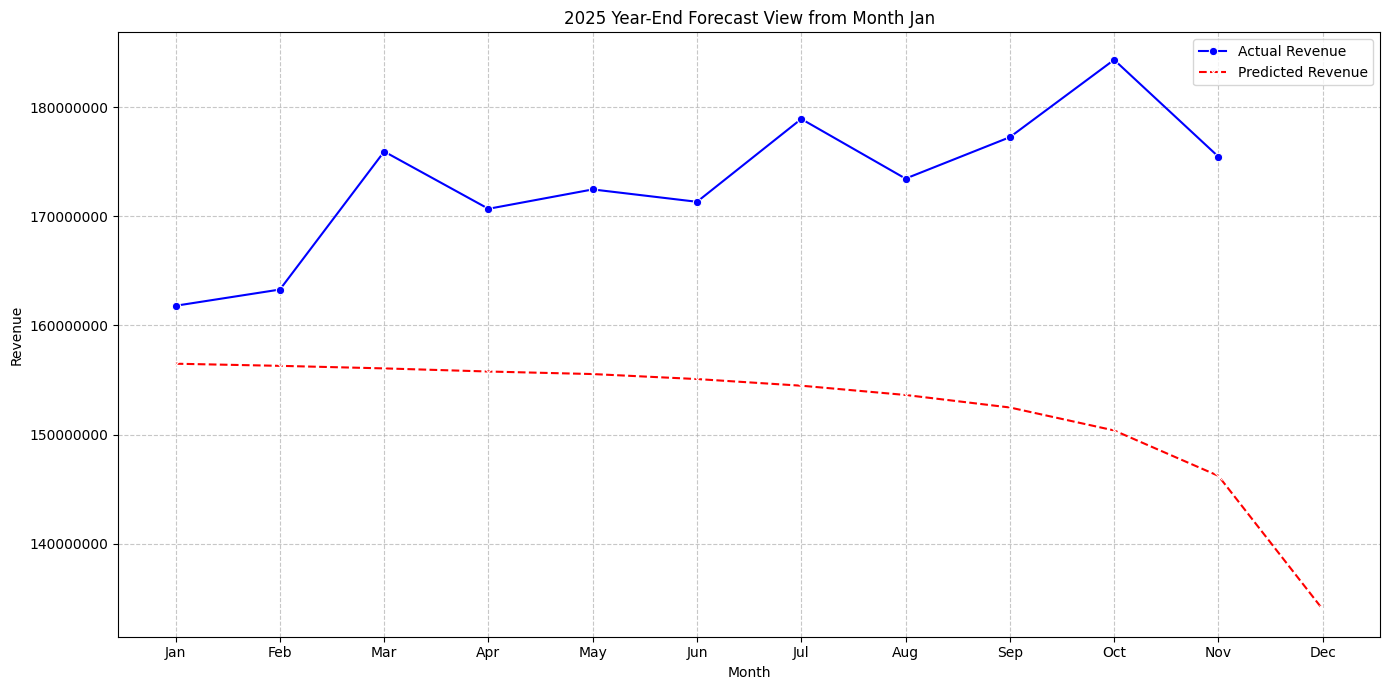

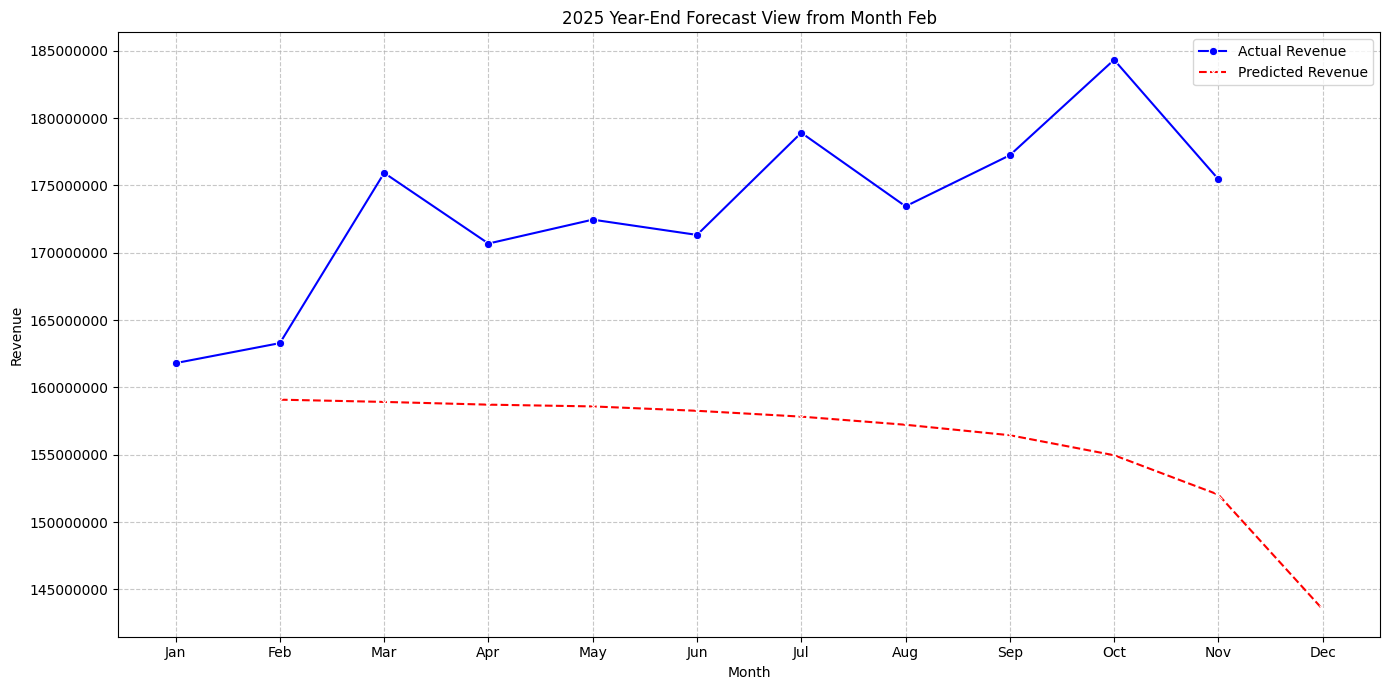

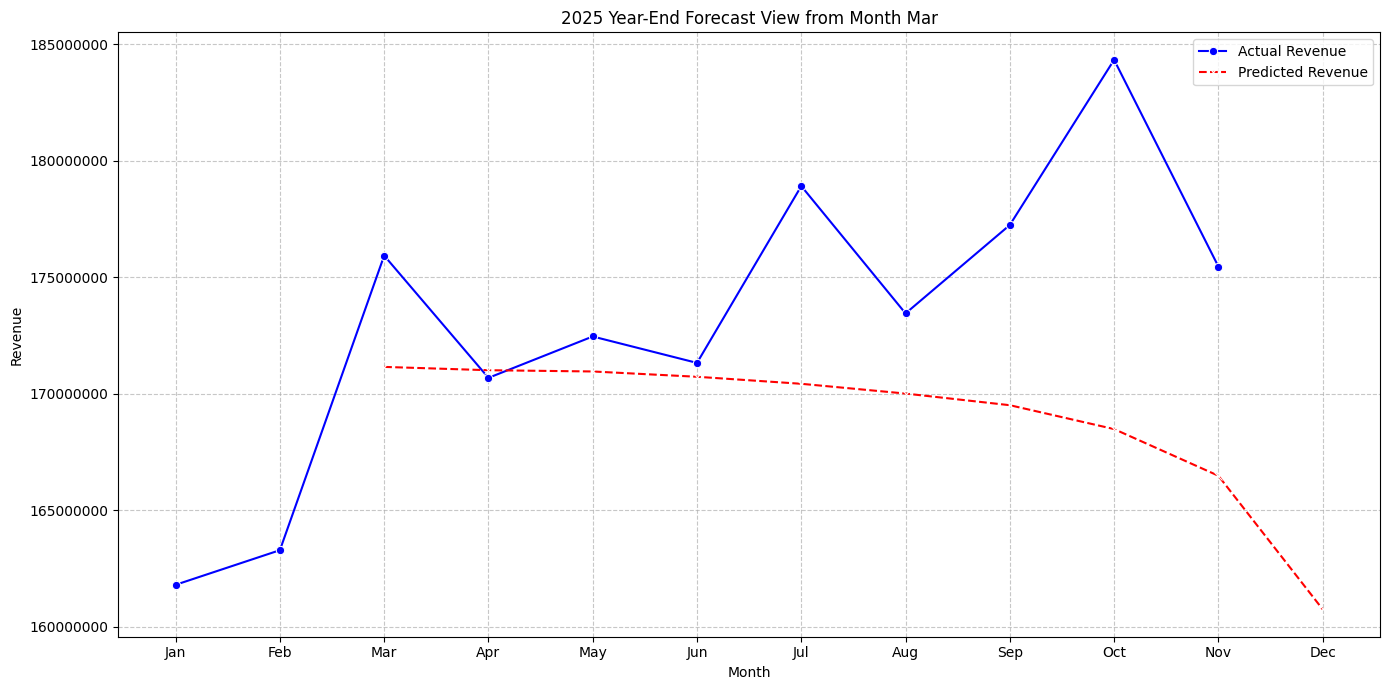

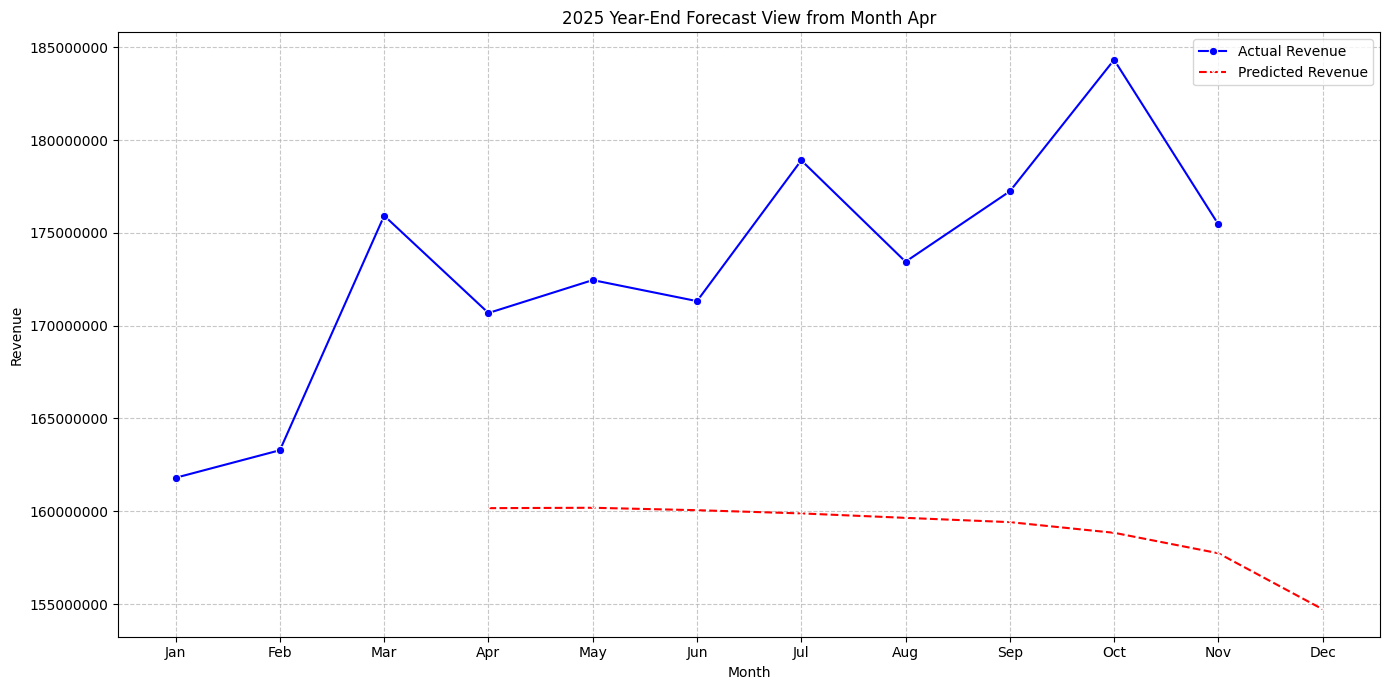

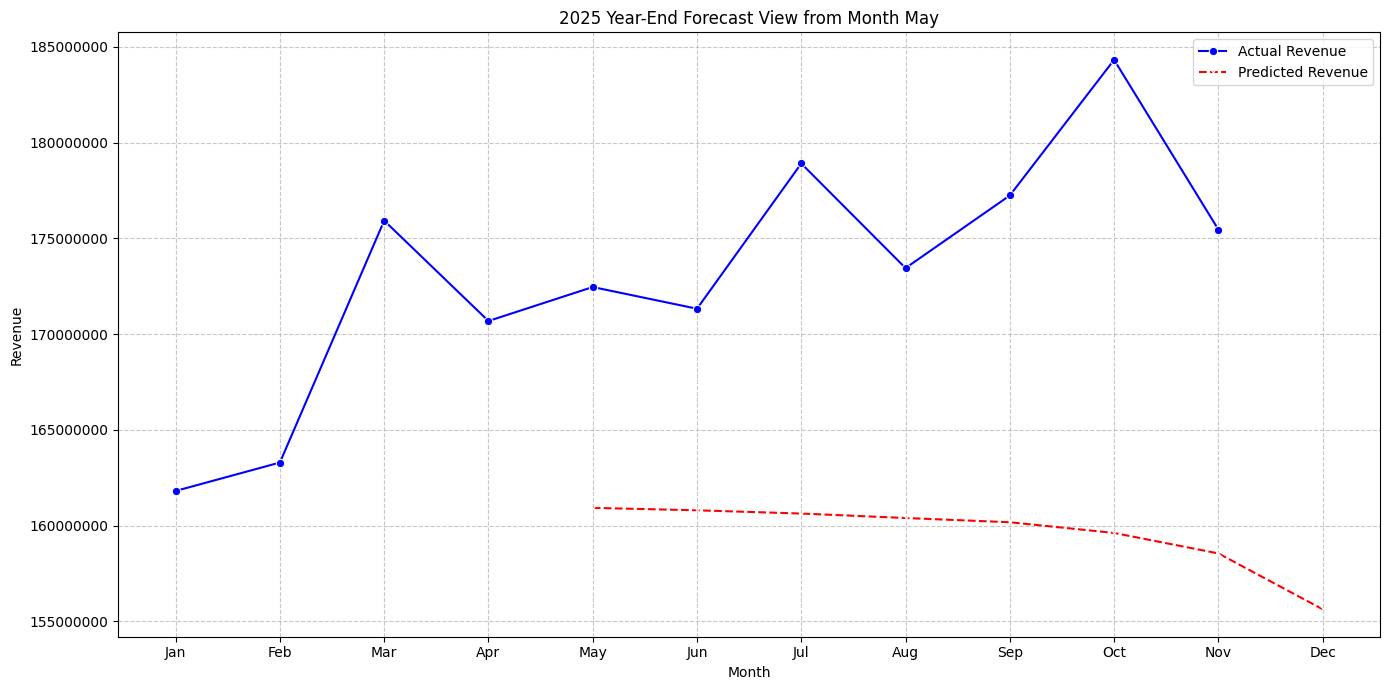

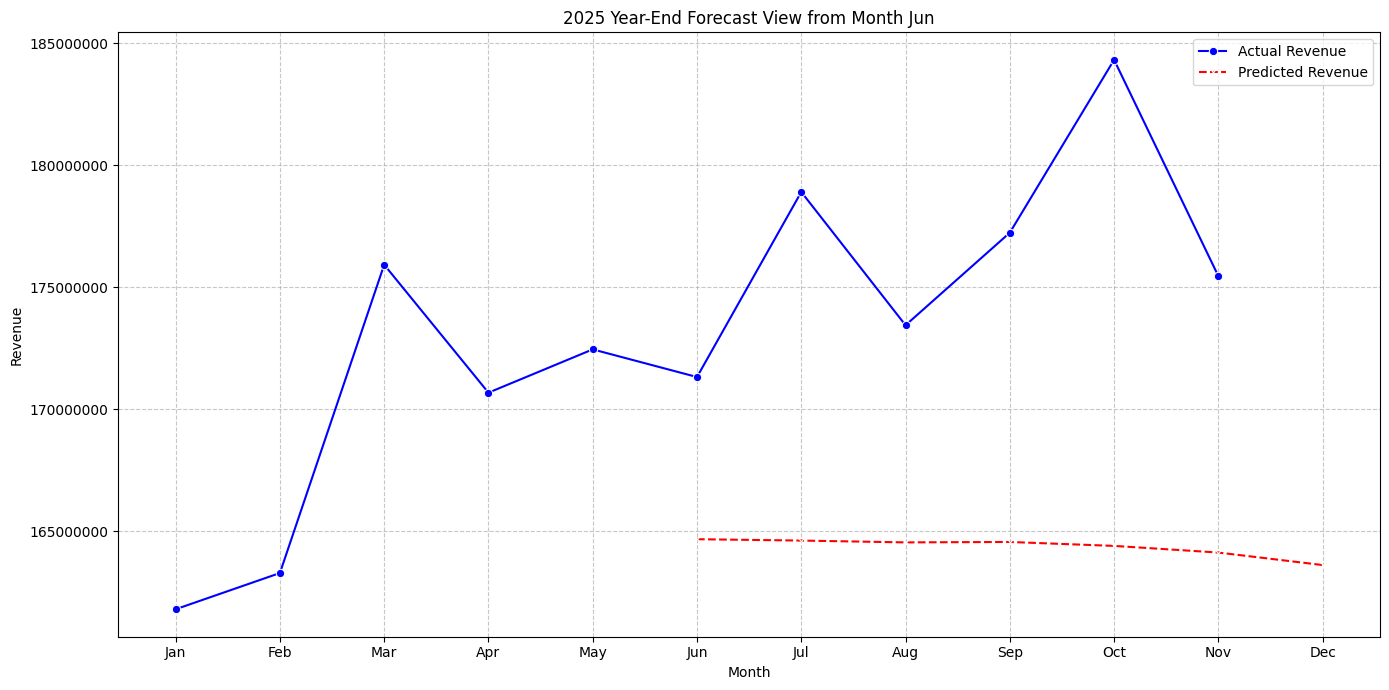

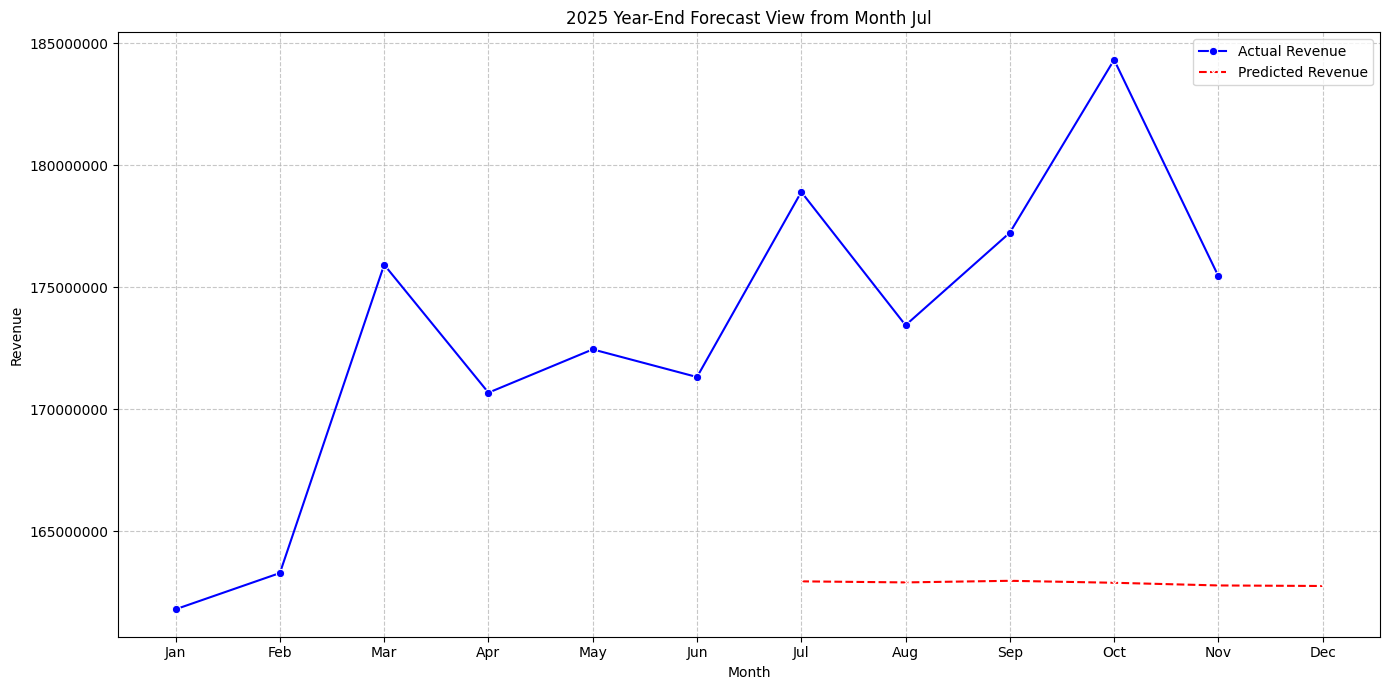

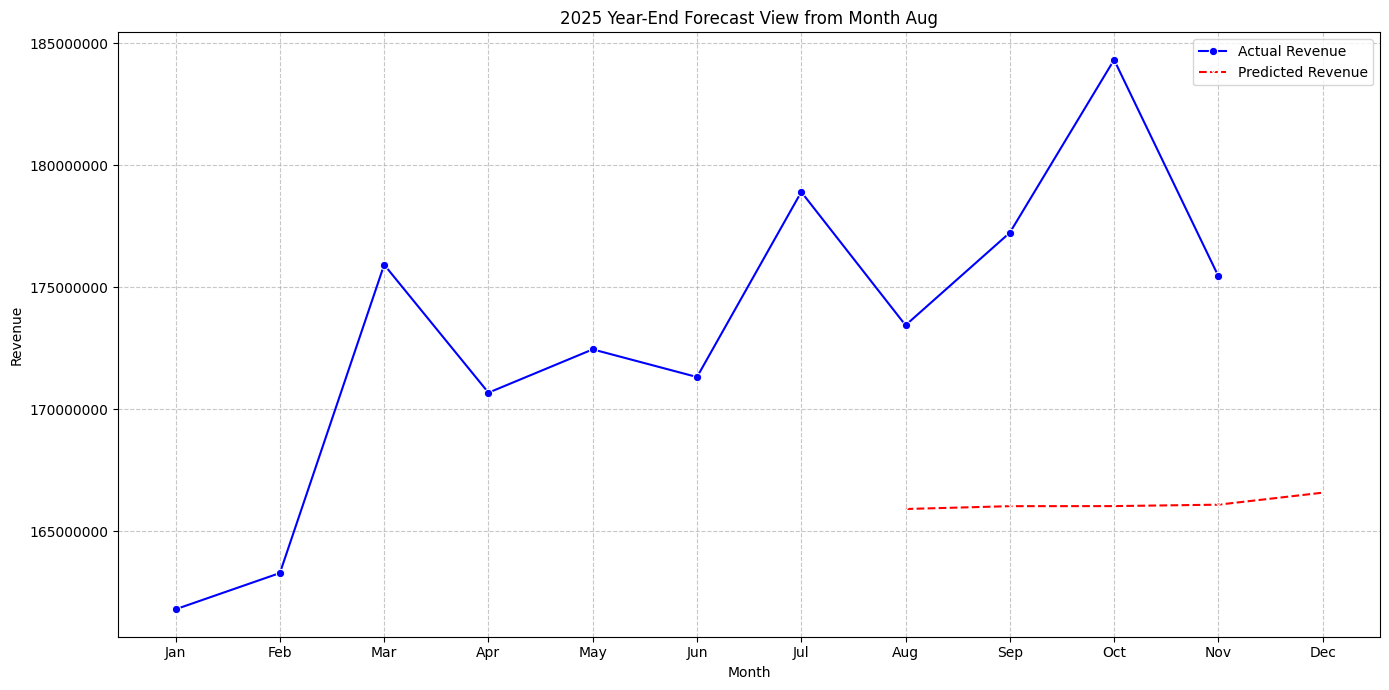

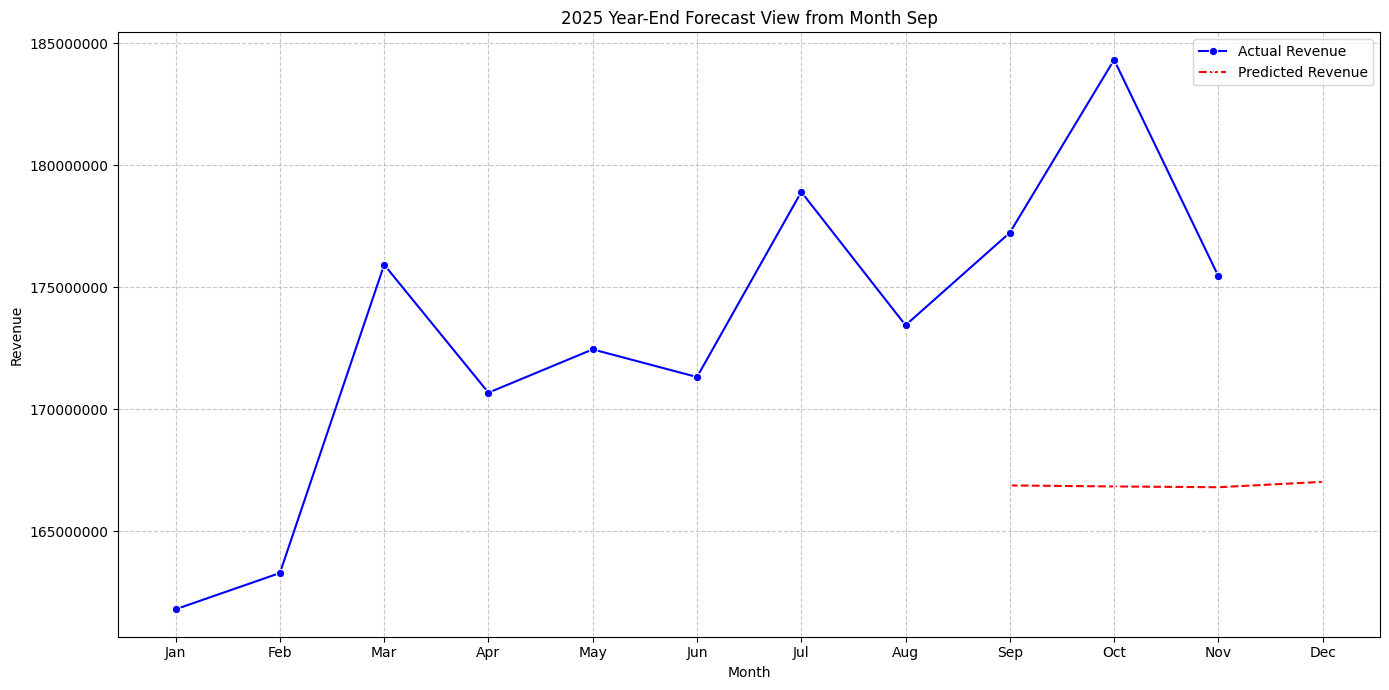

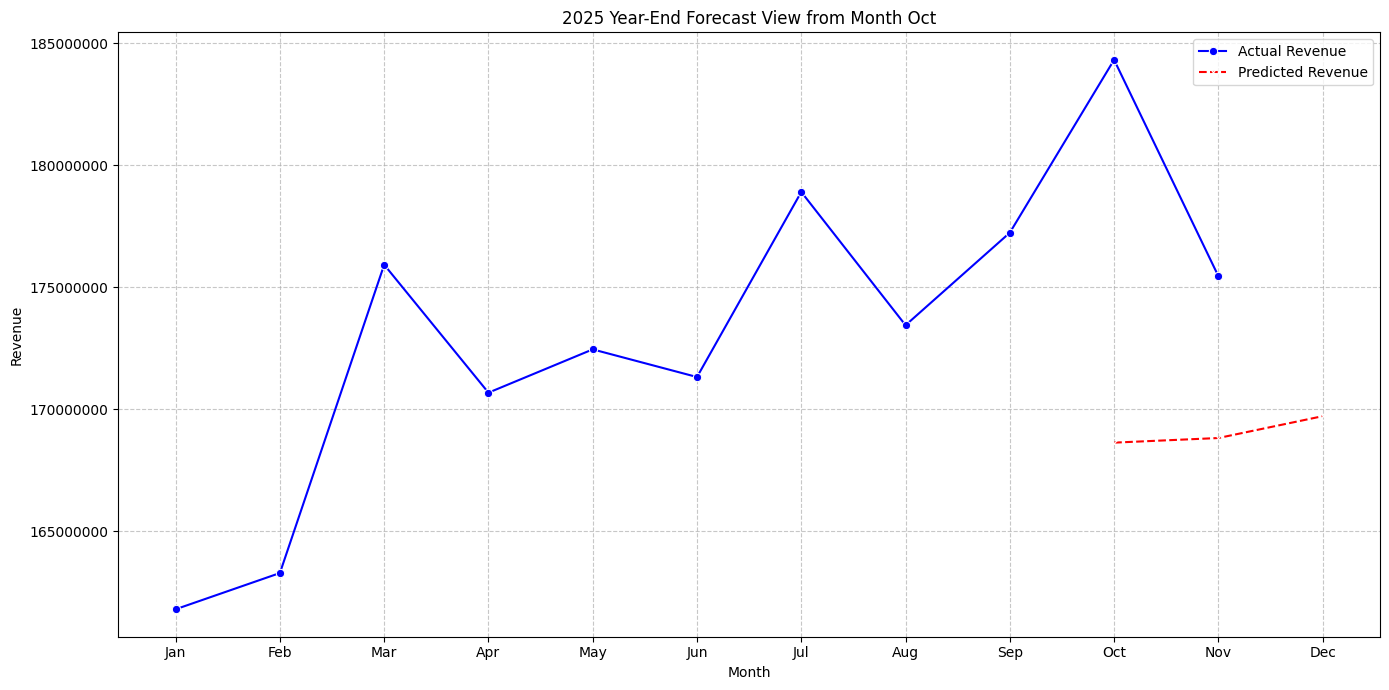

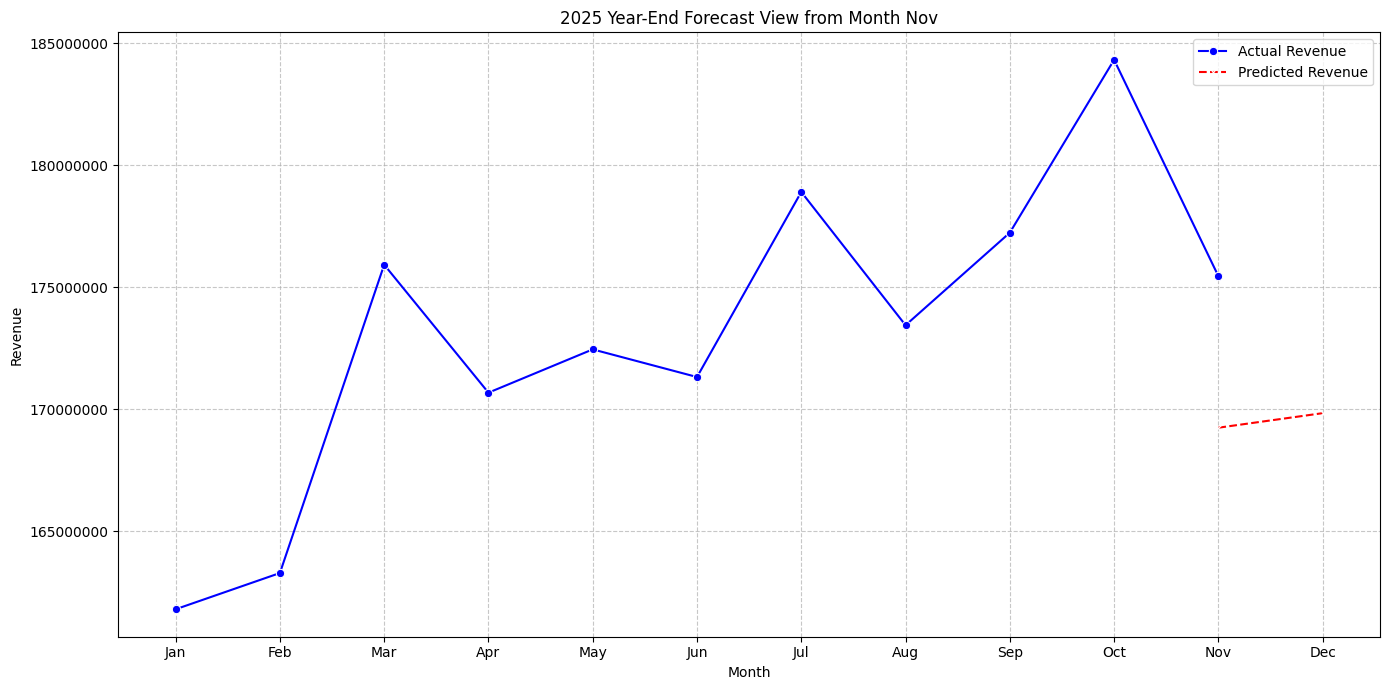

In [92]:
import seaborn as sns
month_names_dict = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

for sitting_month in range(1, 12):
    plot_data_current_view = []
    sitting_month_name = month_names_dict[sitting_month]

    # Iterate through each month m from 1 to 12 (January to December)
    for m in range(1, 13):
        month_name = month_names_dict[m]
        current_actual = np.nan
        current_predicted = np.nan

        if m < sitting_month:
            # Retrieve actual revenue for months before the sitting month
            actual_row = test_df[(test_df['year'] == 2025) & (test_df['month_num'] == m) & (test_df['actual_revenue'].notna())]
            if not actual_row.empty:
                current_actual = actual_row['actual_revenue'].values[0]
        else:
            # Retrieve predictions from the current sitting month onwards
            prediction_row = monthly_results[
                (monthly_results['start_month'] == sitting_month) &
                (monthly_results['forecast_month'] == m)
            ]
            if not prediction_row.empty:
                current_predicted = prediction_row['predicted'].values[0]
                if not prediction_row['is_imputed'].values[0]:
                    # If actual value exists for this forecast month (not imputed)
                    current_actual = prediction_row['actual'].values[0]

        plot_data_current_view.append({'month_name': month_name, 'actual': current_actual, 'predicted': current_predicted})

    df_plot = pd.DataFrame(plot_data_current_view)

    plt.figure(figsize=(14, 7))
    sns.lineplot(x='month_name', y='actual', data=df_plot, marker='o', label='Actual Revenue', color='blue')
    sns.lineplot(x='month_name', y='predicted', data=df_plot, marker='x', linestyle='--', label='Predicted Revenue', color='red')

    plt.title(f'2025 Year-End Forecast View from Month {sitting_month_name}')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:


# if len(yearly_results) > 0:
#     print(f"\n{'Sitting':<10} {'YTD Actuals':>18} {'Predicted M→Dec':>18} {'Year-End Forecast':>20} {'Actual M→Dec':>18} {'Error':>15} {'Avg MAPE':>12}")
#     print("-" * 115)

#     for _, row in yearly_results.iterrows():
#         actual_remaining_str = f"${row['actual_remaining']:,.0f}" if row['actual_remaining'] > 0 else "-"
#         error_str = f"${row['remaining_error']:,.0f}" if not pd.isna(row['remaining_error']) else "-"
#         mape_str = f"{row['avg_mape']:.2f}%" if not pd.isna(row['avg_mape']) else "-"
#         print(f"Month {int(row['start_month']):<4} ${row['ytd_actuals']:>17,.0f} ${row['predicted_remaining']:>17,.0f} ${row['year_end_forecast']:>19,.0f} {actual_remaining_str:>18} {error_str:>15} {mape_str:>12}")

#     # Overall average
#     print("-" * 115)
#     avg_mape_overall = yearly_results['avg_mape'].mean()
#     avg_error = yearly_results['remaining_error'].mean()

#     # Calculate final year-end forecast accuracy
#     final_forecast = yearly_results['year_end_forecast'].iloc[-1] if len(yearly_results) > 0 else 0
#     actual_year_end = yearly_results['year_end_actual'].iloc[-1] if len(yearly_results) > 0 else 0

#     if actual_year_end > 0:
#         final_error_pct = abs(final_forecast - actual_year_end) / actual_year_end * 100
#         print(f"\n Overall Average MAPE across all sitting months: {avg_mape_overall:.2f}%")
#         print(f" Average Remaining Months Error: ${avg_error:,.0f}")
#         print(f" FINAL YEAR-END FORECAST ACCURACY: {final_error_pct:.2f}%")

#     # Feature effectiveness analysis
#     print(f"\n\n ENHANCED FEATURE ENGINEERING RESULTS:")
#     print(f"   Total Features Created: {len(ALL_FEATURES)}")
#     print(f"   Final Features Used: {len(FINAL_FEATURES)}")
#     print(f"   Key Innovation: Monthly Run Rates from cumulative forecasts")
#     print(f"   Business Logic: Time pressure, conversion ratios, health scores")

#     # Show that predictions differ by sitting month
#     print(f"\nVERIFICATION: Predictions differ by sitting month (as expected!)")
#     print(f"   Each sitting month uses its OWN forecast data row.")
#     unique_forecasts = yearly_results['predicted_remaining'].nunique()
#     print(f"   Unique predicted remaining values: {unique_forecasts}")
# else:
#     print("No results to display")